# Home Price Predictive Regression Modeling

## Overview

__Business Problem__

As a business, it is difficult to assess the appropriate value for homes in certain neighborhoods/markets. There is a need for more precision and confidence in valuation to support decision-making. Developing a data-driven / model-based approach to valuation can help to remove human bias.

As a building developer, it is difficult to weigh the importance of attributes to potential home buyers. A model-based approach can help assess what factors drive the overall value of a home.

__Inference Problem__

X: 79 explanatory variables describing aspects of residential homes in Ames, Iowa  
y: Home price

Develop a model to predict home price based on a collection of attributes about the home and surrounding neighborhood.

__Methodology__

- Exploratory data analysis
    - Use pandas profiling minimal for overview
    - Develop calculated metrics using numerical variables
    - Apply one-hot encoding to relevant ordinal variables
- Model setup
    - Set of regression models
        - Basic Linear Regression
        - Comprehensive Linear Regression
        - Suite of advanced models
- Model evaluation and iteration
    - Evaluate performance metrics: $R^2$, MSE, MAE, RMSE
    - Error analysis - residuals
    - Assess feature importance, apply dimensionality reduction
    - Determine which models to exclude, features to exclude/include/adjust
    - Repeat model setup

#### Background Research

*How Zillow calculates home price*

> Zillow publishes Zestimate home valuations for 104 million homes across the country, and uses state of the art statistical and machine learning models that can examine hundreds of data points for each individual home.
>
> To calculate a Zestimate, Zillow uses a sophisticated neural network-based model that incorporates data from county and tax assessor records and direct feeds from hundreds of multiple listing services and brokerages. The Zestimate also incorporates:
>
> * Home characteristics including square footage, location or the number of bathrooms.
> * On-market data such as listing price, description, comparable homes in the area and days on the market
> * Off-market data — tax assessments, prior sales and other publicly available records
> * Market trends, including seasonal changes in demand
> 
> Currently, we have data for over 110 million U.S. homes and we publish Zestimates for 104 million of them.

https://www.zillow.com/research/zestimate-forecast-methodology/

From learning about how Zillow, we could try a neural network-based model, although we might not have enough data. We are provided with solely home characteristics for this project, and it seems like square footage, location, and the number of bathrooms are notable features we should include in our final model.

*Opendoor article on factors that influence home value*

Most important factors:
1. Neighborhood comps
2. Location
3. Home size and usable space
4. Age and condition
5. Upgrades and updates
6. The local market
7. Economic indicators
8. Interest rates

https://www.opendoor.com/w/blog/factors-that-influence-home-value

Based on the Opendoor article, we can potentially engineer features like "usable space" instead of having various features for area.

## 0.0 Project Setup

### 0.1 Import libraries and data

In [1]:
# Basic
from IPython.display import display, Math
import warnings
warnings.filterwarnings('ignore')

# Statistics
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from scipy.stats import chi2_contingency, norm, skew, kurtosis, ttest_ind, probplot

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
import sklearn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from scipy.special import boxcox1p

# Modelling
from sklearn.feature_selection import mutual_info_regression
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import ElasticNet, SGDRegressor, Ridge, Lasso, BayesianRidge, LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

In [2]:
# Read in data locally
house_train = pd.read_csv('../data/train.csv')

## 1.0 Exploratory Data Analysis

### 1.1 Initial EDA

In [3]:
print("\033[1m" + "Dataframe Shape" + "\033[0m")
print(f"The shape of the dataset is {house_train.shape}.")
print("\n")

print("\033[1m" + "Column Information" + "\033[0m")
print("Below are the features and the number of non-null observations of the features")
house_train.info()
print("\n")

print("\033[1m" + "Numeric Column Information" + "\033[0m")
print(house_train.describe())
print("\n")

print("\033[1m" + "Categorical Column Unique Values" + "\033[0m")
for col in house_train:
    if len(house_train[col].unique()) > 10:
        pass
    else:
        print('{}: {}'.format(col, house_train[col].unique()))

Dataframe Shape
The shape of the dataset is (1460, 81).


Column Information
Below are the features and the number of non-null observations of the features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null

In [4]:
# prof = ProfileReport(house_train, minimal=True)
# prof.to_file(output_file='output.html')

The `output.html` file displays information about each variable, including the number of distinct values, missing values, mean, minimum, maximum, and the distribution. From going through the list and reading the description of the features in `data_description.txt`, we chose 3 features to use for our model to predict home price. They are `LotArea`, `BedroomAbvGr`, and `FullBath`. The `LotArea` is the lot size in square feet, `BedroomAbvGr` is the number of bedrooms above grade, and `FullBath` is the number of full bathrooms above grade. We believe these features will be quite predictive of the house price.

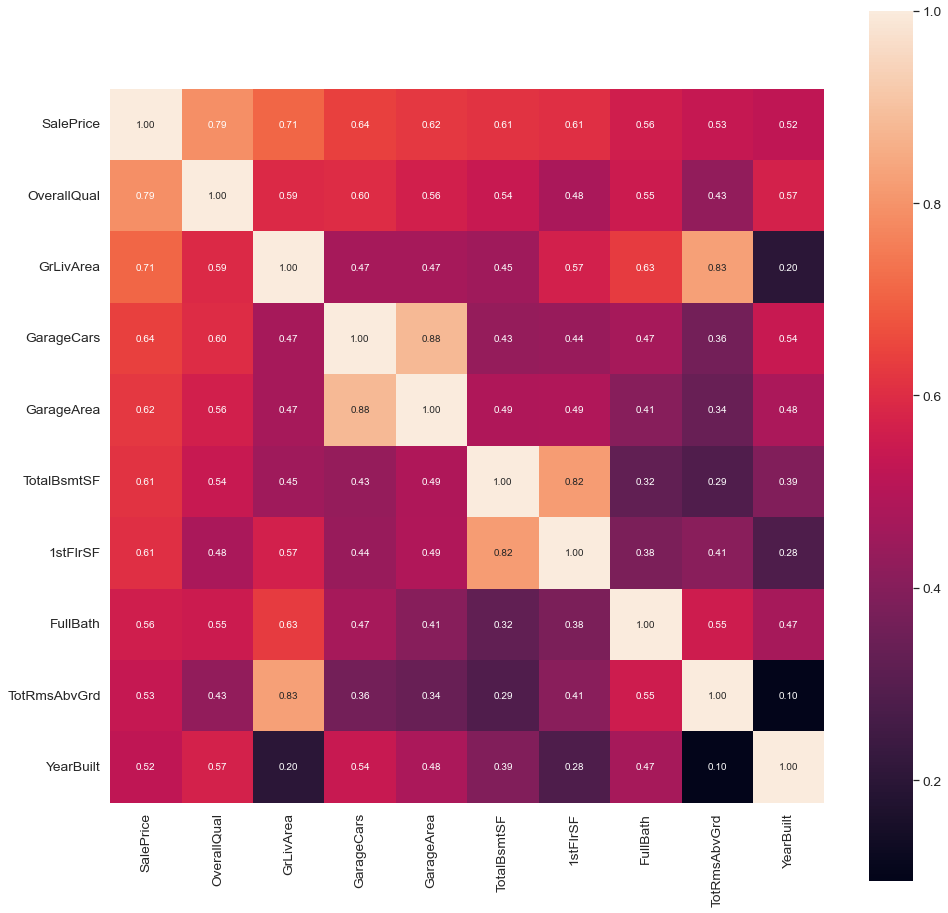

In [5]:
corrmat = house_train.corr()
k = 10

plt.figure(figsize=(16,16))
columns = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
correlation_matrix = np.corrcoef(house_train[columns].values.T)
sns.set(font_scale=1.25)
heat_map = sns.heatmap(correlation_matrix,
                       cbar=True,
                       annot=True,
                       square=True,
                       fmt='.2f',
                       annot_kws={'size': 10},
                       yticklabels=columns.values,
                       xticklabels=columns.values
                      )
plt.show()

#### 1.1 - Insights

1. __Multi-collinearity:__
    1. There are two pairs of variables in the heatmap that appear to show strong relationships with each other. This potentially indicates multi-collinearity, which can obscure model evaluation (coefficients, p-values) for linear regression
        1. (GarageCars, GarageArea)
        1. (TotalBsmtSF, 1stFlrSF)
1. __Predictive variables:__
    1. There are several variables that appear stongly correlated with Sale Price. These will likely be important features to include in our models
        1. OverallQual
        1. GrLivArea
        1. GarageCars
1. __Categorical variables:__
    1. There are several categorical and ordinal variables. These should be evaluated for importance to driving model predictions, and potentially removed and/or grouped in subsequent model iterations.
        1. Example: Neighborhood takes 25 distinct values. After one-hot encoding this field, it is highly unlikely that all of them will be important drivers to model predictions.

## 1.2 - Scatter Plots of SalePrice and Correlated Variables

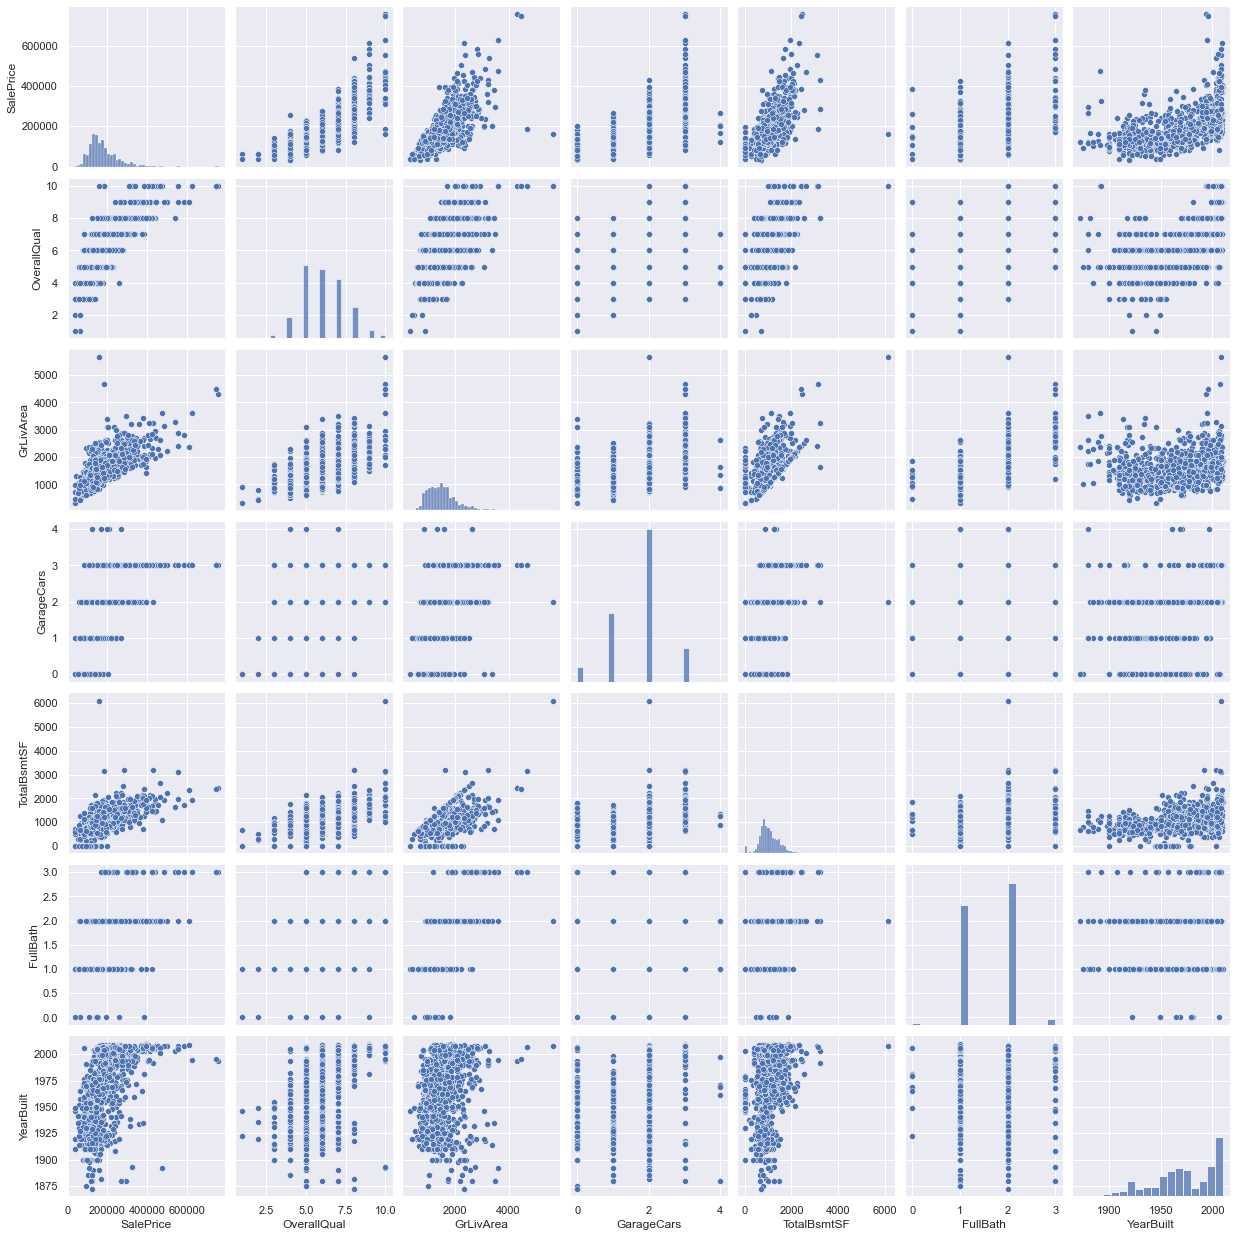

In [6]:
# Create the Scatter Plot,
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house_train[cols], size=2.5)
plt.show()

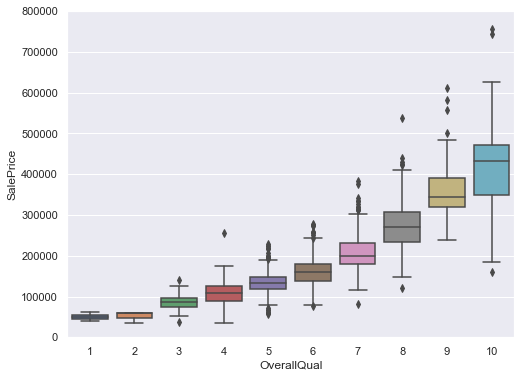

In [7]:
qual_price = pd.concat([house_train['SalePrice'], house_train['OverallQual']], axis=1)

fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=house_train['OverallQual'], y="SalePrice", data=qual_price)
fig.axis(ymin=0, ymax=800000)
plt.show()

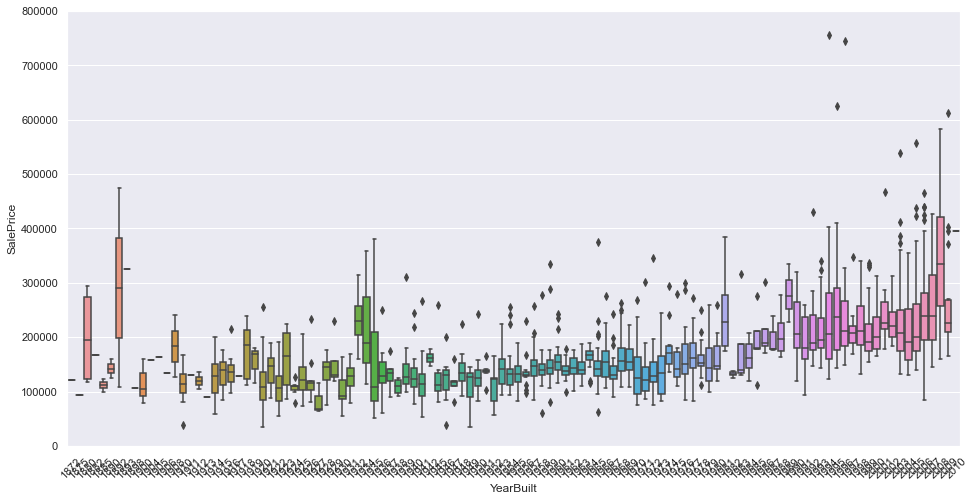

In [8]:
year_price = pd.concat([house_train['SalePrice'], house_train['YearBuilt']], axis=1)
        
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=house_train['YearBuilt'], y="SalePrice", data=year_price)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=45)
plt.show()

## 2.0 Feature Engineering

### 2.1 Handle Missing Data

In [9]:
def missing_ratio(df):
    '''Calculate % of observations with a NaN value for each column of a df'''
    data_na = (df.isnull().sum() / len(df)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index)\
                     .sort_values(ascending=False)[:30]

    missing_data = pd.DataFrame({'Missing Ratio': data_na})
    return missing_data

missing_ratio(house_train)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945
GarageQual,5.547945


In [10]:
def handle_missing_data(df,
                        drop_features=None,
                        none_features=None,
                        med_features=None,
                        mode_features=None,
                        convert_features=None
                       ):
    '''
    Perform basic feature engineering as applicable to each feature / set of features.
    Includes imputation of NaN, mean normalization, and feature dropping.

    df:                the dataframe to be transformed
    drop_features:     columns that should be dorpped from the dataframe
    none_features:     columns where NaN should be replaced with None or 0
    med_features:      numeric columns where NaN should be replaced with the median value
    mode_features:     numeric columns where NaN should be replaced with the mode value
    convert_features:  numeric columns that should be converted to ordinal features
    '''
    
    df = df.drop(drop_features, axis=1)

    for feature in none_features:
        if df[feature].dtype == 'O':
            df[feature] = df[feature].fillna("None")
        else:
            df[feature] = df[feature].fillna(0)
    
    for feature in med_features:
        df[feature] = df[feature].fillna(df[feature].median()[0])
    
    for feature in mode_features:
        df[feature] = df[feature].fillna(df[feature].mode()[0])
    
    for feature in convert_features:
        df[feature] = df[feature].astype(str)
    
    return df

### 2.1 - Notes:

1. __Data imputation:__
    1. Looking at some of the features that are missing values such as PoolQC or Fence, we can assume that due to the lack of commonality that the features themselves aren't missing imput, but rather the NaN values should be 0 (suggesting a lack of a pool or fence).
1. __Missing data:__
    1. Consider excluding features that >= 15% NaN; as they cannot be logically imputed and are unlikely to hold predictive power. 
    1. Consider excluding or normalizing features with significant outliers
        1. PoolQC
        1. MiscFeature

In [11]:
# Features to drop from df
drop_features = ['Id', 'Utilities'] # all same value except for 2 NA

# Features to replace NaN with None or 0 - logical assumption that NaN means the house does not have X feature
none_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'BsmtQual',
                 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType',
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt',
                 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea', 'MSSubClass'
                ]

# Features to fill NaN with the median value of the column
med_features = []


# Features to fill NaN with the mode value of the column
mode_features = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd',
                 'SaleType'
                ]
    
# Numeric features that are actually ordinal and should be converted
# convert_features = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
convert_features = ['MSSubClass', 'OverallCond']


house_train_copy = house_train.copy()


### 2.2 Assumptions

        
Now that we have cleaned the data and explored some of the variables we need to test the assumptions underlying the statistical basis for multivariate analysis. It is important to check that 'SalePrice' complies with the statistical assumptions we are using. 

##### Assumptions:

- __Normality:__ The data should look like a normal distribution. Here we will check univariate normality of 'SalePrice'. For large data sets (>200 observations) normality is not much of an issue, but if solved for normality we can avoid issues such as hetrosceddacity. This being said univariate normality does not indicate multivariate normality (but it is a good start).

- __Homeocedasticity:__ Assumption that independent variables exhibit equal levels of variance across the range of predictor variables. We are looking for an error term that is the same across all values of the independent variable.

- __Linearity:__ Examine scatter plots and search for linear patterns. If they are not linear we can explore data transformation methods. So far most scatter plots have had roughly linear relationships.

- __Absence of correlated errors:__ This is common with time series and happens when one error is correlated with another. To solve this we would add a variable that can explain the temporal effect we are getting. (we will not touch on this).

#### Normality

In [12]:
# Look at SalePrice distribution
house_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [13]:
print(f'SalePrce Swewness: {house_train["SalePrice"].skew()}')
print(f'SalePrice Kurtosis: {house_train["SalePrice"].kurt()}')

SalePrce Swewness: 1.8828757597682129
SalePrice Kurtosis: 6.536281860064529


### Notes

Looking at the histogram of home SalePrice:
- The chart deviates from a normal distribution
- Histogram is skewed right with a skewness of 1.88
- Kurtosis of 6.5

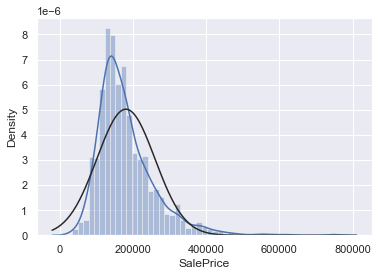

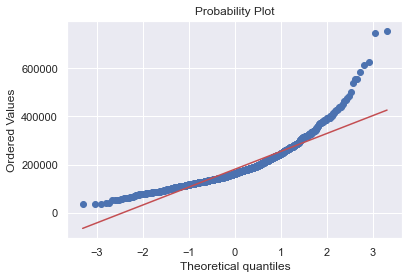

In [14]:
# Histogram and probability plot
sns.distplot(house_train['SalePrice'], fit=norm)
fig = plt.figure()
res = probplot(house_train['SalePrice'], plot=plt)

### 2.2 Notes
Looking at the histogram we can see peakedness and positive skewness (not a normal distribution). In the case of positive skewness we can use a log transformation to try and make the variable more normally distributed.

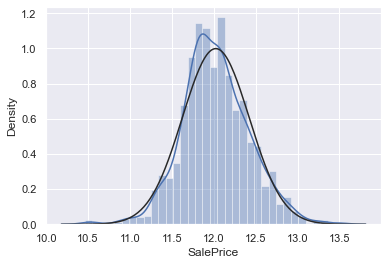

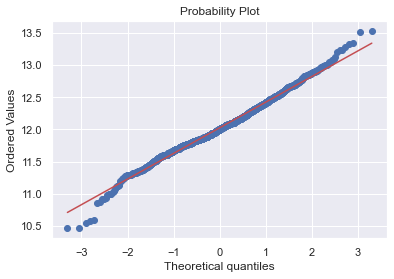

In [15]:
# apply a log transformation
sale_price_log = np.log(house_train['SalePrice'])
       
sns.distplot(sale_price_log, fit=norm)
fig = plt.figure()
res = probplot(sale_price_log, plot=plt)

### 2.2 Notes - Continued

       
Other Important variables:
- GrLivArea
- TotalBsmtSF
- HasBsmt

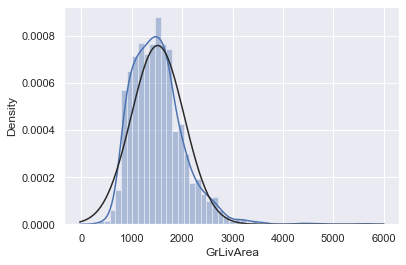

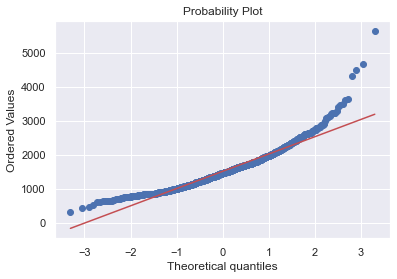

In [16]:
# Histogram and probability plot
sns.distplot(house_train['GrLivArea'], fit=norm)
fig = plt.figure()
res = probplot(house_train['GrLivArea'], plot=plt)

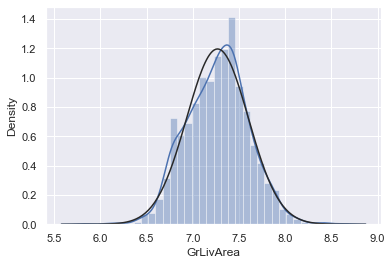

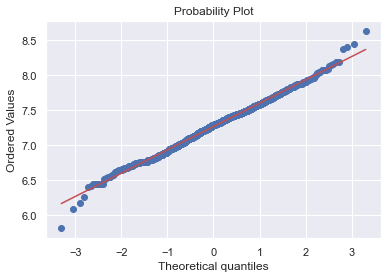

In [17]:
# Data transformation
grlivarea_log = np.log(house_train['GrLivArea'])

# Transformed histogram and normal probability plot
sns.distplot(grlivarea_log, fit=norm)

fig = plt.figure()
res = probplot(grlivarea_log, plot=plt)

In [18]:
# Create column for new variable (one is enough because it's a binary categorical feature)
# If area>0 it gets 1, for area==0 it gets 0
house_train_copy['HasBsmt'] = pd.Series(len(house_train_copy['TotalBsmtSF']), index=house_train_copy.index)
house_train_copy['HasBsmt'] = 0
house_train_copy.loc[house_train_copy['TotalBsmtSF']>0,'HasBsmt'] = 1

In [19]:
# Transform data
house_train_copy.loc[house_train_copy['HasBsmt']==1,'TotalBsmtSF'] = np.log(house_train_copy['TotalBsmtSF'])

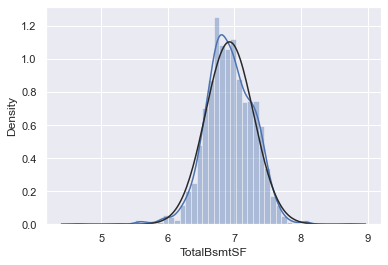

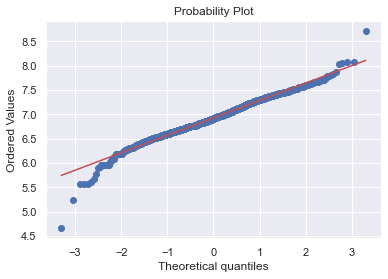

In [20]:
# Histogram and normal probability plot
sns.distplot(house_train_copy[house_train_copy['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()

res = probplot(house_train_copy[house_train_copy['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

### Homoscedasticity
Here we can plot the variables and 'SalePrice' to check the dispersion of the scatter plots

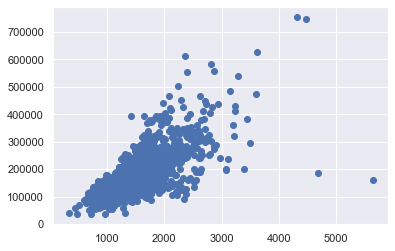

In [21]:
# Scatter plots of original
plt.scatter(house_train['GrLivArea'], house_train['SalePrice'])
plt.show()

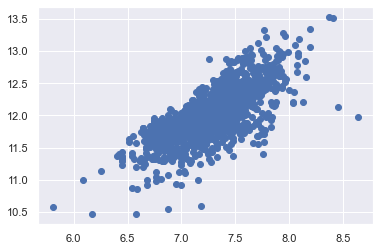

In [22]:
# Scatter plot with log transform
plt.scatter(grlivarea_log, sale_price_log)
plt.show()

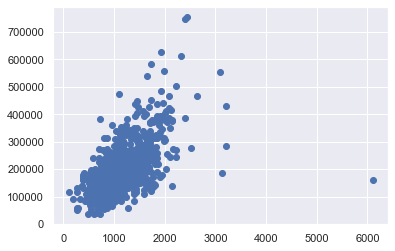

In [23]:
# Scatter plot of TotalBsmtSF and SalePrice
plt.scatter(house_train[house_train['TotalBsmtSF']>0]['TotalBsmtSF'],
            house_train[house_train['TotalBsmtSF']>0]['SalePrice']
           )
plt.show()

### 2.2 Custom transformation

In [24]:
def custom_feature_engineering(df, train=True):
    '''Apply custom operations to dataframe. Contained in a function for re-use with test data'''

    # Fill NaN values for LotFrontage with median in each neighborhood
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # For Functional column, data_description.txt indicates that NaN = Typ
    df['Functional'] = df['Functional'].fillna('Typ')

    # Calculate total sqft of house as a new feature
    df['TotalSF'] = df[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']].sum(axis=1)
         
    # Total Bathrooms
    df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    
    # Total porch sq foot
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])

    # basement feature
    df['HasBsmt'] = pd.Series(len(df['TotalBsmtSF']), index=df.index)
    df['HasBsmt'] = 0
    df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1
    
    # Log of original feature
    df['GrLivAreaLog'] = np.log(df['GrLivArea'])
    
    if train:
        df['SalePriceLog'] = np.log(df['SalePrice'])



    return df

### 2.3 Feature Selection and Importance

In [25]:
def feature_importance(X, y):

    X = X.copy()
    # Change discrete features to integer types
    for colname in X.select_dtypes(["object"]):
        X[colname], _ = X[colname].factorize()
    # get MI score for features
    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores


def remove_uninformative_cols(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]


def plot_mi_score(mi_score):

    sorted_scores = mi_score.sort_values(ascending=True)
    bar = np.arange(len(sorted_scores))
    ticks = list(sorted_scores.index)
    # Populate Graph
    plt.figure(num=1, figsize=(10,14))
    plt.barh(bar, sorted_scores)
    plt.yticks(bar, ticks)
    # Labels and title
    plt.ylabel("Feature")
    plt.xlabel("MI Score")
    plt.title('Mutual Info Scores')


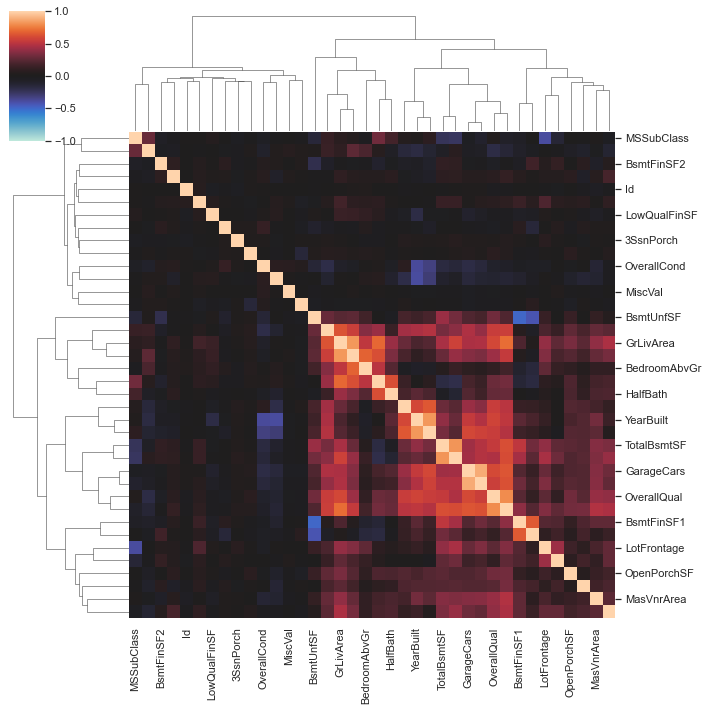

In [26]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )

corrplot(house_train, annot=None)

### 2.4 Normalizing variables

In [27]:
def normalize_skewed_features(df, train=True):
    # Calculate skew and kurtosis of all numerical features
    num_features = df.dtypes[df.dtypes != "object"].index
    skew_features = df[num_features].apply(lambda x: pd.Series({'skew': x.skew(),
                                                                'kurtosis': x.kurtosis()
                                                               }))
    skew_df = pd.DataFrame({'skew': skew_features.loc['skew'],
                            'kurtosis': skew_features.loc['kurtosis']
                           }).sort_values(by='skew', ascending=False)

    
    if train:
        skew_df.drop(['SalePrice'], inplace=True)
    
    # Use a power transformer to normalize all featuers with skew > 1
    skew_df = skew_df[abs(skew_df['skew']) > 1]
    skewed_features = list(skew_df.index)
    pt = PowerTransformer()
    df[skewed_features] = pt.fit_transform(df[skewed_features])
    
    return df

In [28]:
# Explore skew and kurtosis functions in pandas and scipy
pd_skew    = house_train['LotArea'].skew()
pd_kurt    = house_train['LotArea'].kurt()
sci_skew   = skew(house_train['LotArea'], bias=False)
sci_kurt   = kurtosis(house_train['LotArea'], bias=False)
sci_skew_b = skew(house_train['LotArea'], bias=True)
sci_kurt_b = kurtosis(house_train['LotArea'], bias=True)

pd.DataFrame({'skew': [pd_skew, sci_skew, sci_skew_b],
              'kurtosis': [pd_kurt, sci_kurt, sci_kurt_b]},
             index=['pandas', 'scipy-unbiased', 'scipy-biased']
            )

,skew,kurtosis
pandas,12.207688,203.243271
scipy-unbiased,12.207688,203.243271
scipy-biased,12.195142,202.543793


In [29]:
# Calculate skew and kurtosis of all numerical features
num_features = house_train.dtypes[house_train.dtypes != "object"].index
skew_features = house_train[num_features].apply(lambda x: pd.Series({'skew': x.skew(),
                                                                     'kurtosis': x.kurtosis()
                                                                    }))
skew_df = pd.DataFrame({'skew': skew_features.loc['skew'],
                        'kurtosis': skew_features.loc['kurtosis']
                       }).sort_values(by='skew', ascending=False)
skew_df

,skew,kurtosis
MiscVal,24.476794,701.003342
PoolArea,14.828374,223.268499
LotArea,12.207688,203.243271
3SsnPorch,10.304342,123.662379
LowQualFinSF,9.011341,83.234817
KitchenAbvGr,4.488397,21.532404
BsmtFinSF2,4.255261,20.113338
ScreenPorch,4.122214,18.439068
BsmtHalfBath,4.103403,16.396642
EnclosedPorch,3.089872,10.430766


In [30]:
# Apply boxcox transformation to skewed features
# Explore 2 methods using highly skewed feature
temp = pd.DataFrame(house_train['LotArea'])

# Take the log10 of votes
temp['LotArea_Norm'] = boxcox1p(temp['LotArea'], 0)

# Apply power transformation
pt = PowerTransformer()
temp['LotArea_Power'] = pt.fit_transform(pd.DataFrame(temp['LotArea']))


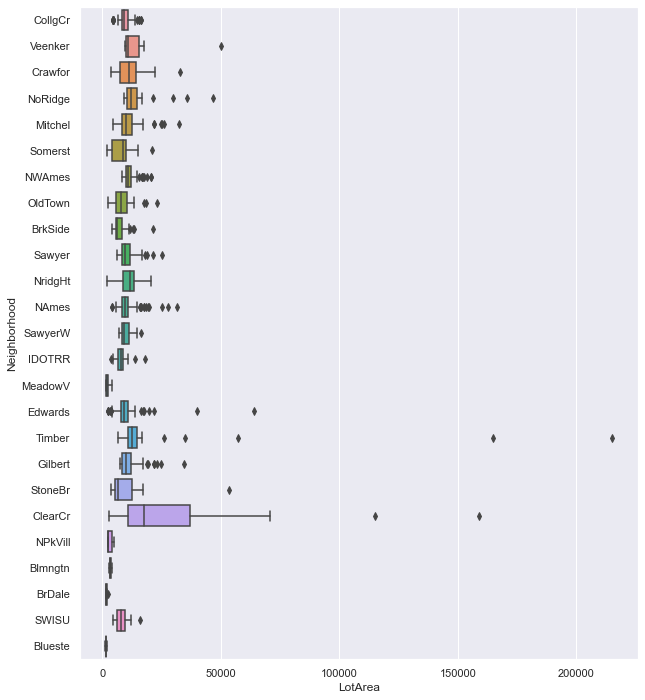

In [31]:
fig, ax = plt.subplots(figsize=(10,12))
sns.boxplot(x='LotArea', y='Neighborhood', orient='h', data=house_train)
plt.show()

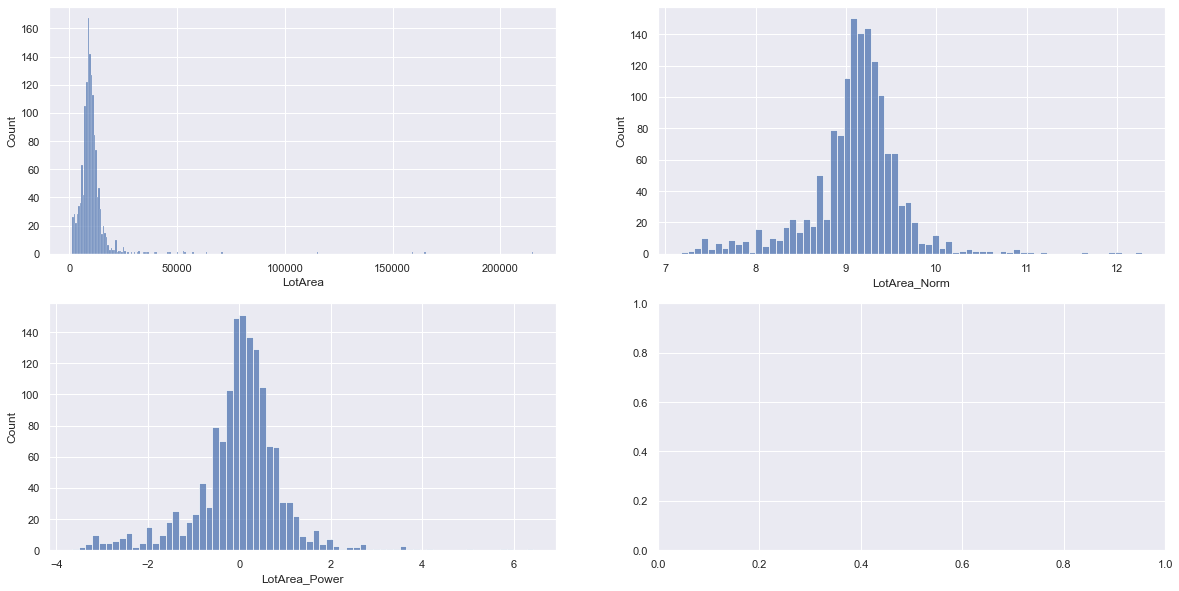

In [32]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.histplot(x='LotArea',
             data=temp,
             ax=ax[0][0]
            )

sns.histplot(x='LotArea_Norm',
             data=temp,
             ax=ax[0][1]
            )

sns.histplot(x='LotArea_Power',
             data=temp,
             ax=ax[1][0]
            )

plt.show()

### 2.X Apply functions to training data

In [33]:
house_train = handle_missing_data(house_train,
                                  drop_features,
                                  none_features,
                                  med_features,
                                  mode_features,
                                  convert_features
                                 )

house_train = custom_feature_engineering(house_train)
house_train = normalize_skewed_features(house_train)

# Simple pandas function to replicate a OneHotEncoder
house_train = pd.get_dummies(house_train)

In [34]:
# Check that there are no remaining missing values
missing_ratio(house_train)

,Missing Ratio


## 3.0 Model building

In [35]:
def calculate_residuals(predictions, actuals):
    residuals = actuals - predictions
    return residuals

In [36]:
def plot_residual(y_pred, y_dev, model_name='Linear Regression v1'):
    residuals = calculate_residuals(y_pred, y_dev)
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Value')
    plt.ylabel('Residals')
    plt.title(f"Residual Plot of {model_name}")
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()

In [37]:
# Get the data samples with the largest residuals
def get_largest_residuals(y_pred, y_dev, n=10):
    residuals = calculate_residuals(y_pred, y_dev)
    absolute_residuals = abs(residuals)
    integer_indices = np.flip(np.argsort(absolute_residuals))[:n] # top n largest residuals
    top_residuals = absolute_residuals.iloc[integer_indices]
    return X_dev.loc[top_residuals.index]

In [38]:
def get_p_values_of_difference(X_largest_residuals, X_dev):
    for column in X_largest_residuals.columns:
        p_value = ttest_ind(X_largest_residuals[column], X_dev[column])[1]
        bonferroni_threshold = 0.05 / len(X_largest_residuals.columns)
        if p_value < bonferroni_threshold:
            significance = ", Statistically significant"
        else:
            significance = ""
        print(f"{column} p-value: {round(p_value, 3)}{significance}")

### 3.1 Model v1 - Simple linear regression

For our baseline, we are building a linear regression model with `LotArea`, `BedroomAbvGr`, and `FullBath` as features.

In [39]:
def split_model(X, y):
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_dev, y_train, y_dev

def evaluate_model(X_train, X_dev, y_train, y_dev, model_type, initial_model=False):
    X_train, X_dev, y_train, y_dev = split_model(X, y)
    if model_type == 'linear_regression':
        model = LinearRegression()
    if model_type == 'xgboost':
        model = xgb.XGBRegressor(colsample_bytree=0.4603,
                           gamma=0.0468, 
                           learning_rate=0.05,
                           max_depth=3, 
                           min_child_weight=1.7817,
                           n_estimators=2200,
                           reg_alpha=0.4640,
                           reg_lambda=0.8571,
                           subsample=0.5213,
                           silent=1,
                           random_state=7,
                           nthread=-1
                          )
    fitted_model = model.fit(X_train, y_train)
    r2 = fitted_model.score(X_dev, y_dev)

    if initial_model:
        x1, x2, x3 = fitted_model.coef_
        intercept = fitted_model.intercept_
        print("The initial model function is: y = {:.2f}x1 + {:.2f}x2 + {:.2f}x3 + {:.2f}".format(x1, x2, x3, intercept))

    model_name = ' '.join(model_type.split('_')).title()
    display(Math(r'\text{{{}}} \text{{ model performance metrics}}'.format(model_name)))

    y_pred = fitted_model.predict(X_dev)
    mae = mean_absolute_error(y_dev, y_pred)
    mse = mean_squared_error(y_dev, y_pred, squared=True)
    rmse = mean_squared_error(y_dev, y_pred, squared=False)
    

    display(Math(r'R^2 \text{{: }} {:.2f}'.format(r2)))
    display(Math(r'\text{{MAE: }} {:.2f}'.format(mae)))
    display(Math(r'\text{{MSE: }} {:.2f}'.format(mse)))
    display(Math(r'\text{{RMSE: }} {:.2f}'.format(rmse)))
    
    return y_pred, fitted_model


In [40]:
initial_features = ['LotArea', 'BedroomAbvGr', 'FullBath']

X, y = house_train[initial_features], house_train['SalePriceLog']
X_train, X_dev, y_train, y_dev = split_model(X, y)

y_pred, lr_model = evaluate_model(X_train, X_dev, y_train, y_dev, 'linear_regression', initial_model=True)

The initial model function is: y = 0.13x1 + -0.05x2 + 0.40x3 + 11.53


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Calculate residuals

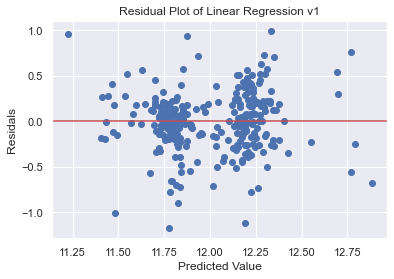

In [41]:
plot_residual(y_pred, y_dev)

The residual plot suggests a good fit. It is quite symmetrically distributed, tending to cluster towards the middle of the plot as there are more values predicted towards the mean. They are clustered around the 0 and not overly high. There isn't a strong pattern although there are residuals with a low value associated with examples with low predicted value as well.

### Individual feature error analysis

In [42]:
top_10_percent_of_X_dev = int(X_dev.shape[0] * 0.1)
X_largest_residuals = get_largest_residuals(y_pred, y_dev, n=top_10_percent_of_X_dev)
# looking at the data with the largest residuals
X_largest_residuals

,LotArea,BedroomAbvGr,FullBath
30,-0.129783,3,1
1432,0.334274,4,2
916,-0.019335,1,0
898,0.683684,2,2
597,-1.605292,2,0
1228,-0.069603,1,1
812,-0.082204,2,1
636,-0.760780,1,1
736,-0.119814,2,2
691,1.690959,4,3


In [43]:
# for each feature, look at the p-values of the difference between the top residuals and the data overall
get_p_values_of_difference(X_largest_residuals, X_dev)

LotArea p-value: 0.102
BedroomAbvGr p-value: 0.02
FullBath p-value: 0.548


### 3.2 Model v2 - Linear regression with complete set of features

In [44]:
X, y = house_train.drop(['SalePrice','SalePriceLog'], axis=1), house_train['SalePriceLog']
X_train, X_dev, y_train, y_dev = split_model(X, y)
y_pred, lr_model = evaluate_model(X_train, X_dev, y_train, y_dev, 'linear_regression')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

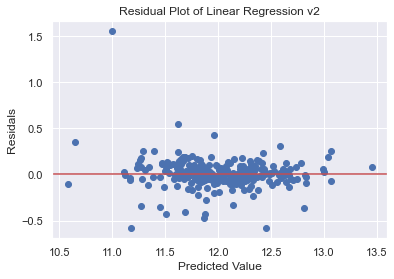

In [45]:
plot_residual(y_pred, y_dev, model_name = 'Linear Regression v2')

The residual plot suggests a good fit generally, but it has some outliers. Other than the outliers, the residual plot is also quite symmetrically distributed, tending to cluster towards the middle of the plot as there are more values predicted towards the mean. They are clustered around the 0 and not overly high. There isn't a strong pattern.

In [46]:
top_10_percent_of_X_dev = int(X_dev.shape[0] * 0.1)
X_largest_residuals = get_largest_residuals(y_pred, y_dev, n=top_10_percent_of_X_dev)
# looking at the data with the largest residuals
X_largest_residuals

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
332,0.728301,0.307990,8,2003,2004,1.304910,1.107799,2.783551,1603,4.137573,...,0,0,0,1,0,0,0,0,1,0
588,-0.159666,1.995644,5,1968,2003,-0.818452,1.225185,-0.359384,113,0.876671,...,0,0,0,1,0,0,0,0,0,1
30,-0.927855,-0.129783,4,1920,1950,-0.818452,-1.353159,-0.359384,649,-0.911841,...,0,0,0,1,0,0,0,0,1,0
597,-0.765225,-1.605292,7,2006,2007,1.017288,-1.353159,-0.359384,1258,0.499604,...,0,1,0,0,0,0,0,0,0,1
479,-0.927855,-0.822632,4,1937,2000,1.367881,0.024860,-0.359384,739,-0.284079,...,0,0,0,1,0,0,1,0,0,0
1432,-0.403999,0.334274,4,1927,2007,-0.818452,-1.353159,-0.359384,656,-0.894038,...,0,0,0,1,0,0,0,0,1,0
271,0.211095,2.887180,7,1954,2005,-0.818452,0.164155,2.783735,96,0.768461,...,0,0,0,1,0,0,0,0,1,0
1131,-0.256143,0.318363,5,1991,1992,-0.818452,0.133301,-0.359384,762,-0.129128,...,0,0,1,0,1,0,0,0,0,0
589,-0.927855,0.002039,5,1930,1960,-0.818452,-1.353159,-0.359384,742,-0.679157,...,0,0,0,1,0,0,0,0,1,0
581,1.245853,0.650871,8,2008,2009,1.310578,-1.353159,-0.359384,2042,2.070889,...,0,1,0,0,0,0,0,0,0,1


In [47]:
# for each feature, look at the p-values of the difference between the top residuals and the data overall
get_p_values_of_difference(X_largest_residuals, X_dev)

LotFrontage p-value: 0.917
LotArea p-value: 0.302
OverallQual p-value: 0.264
YearBuilt p-value: 0.027
YearRemodAdd p-value: 0.46
MasVnrArea p-value: 0.995
BsmtFinSF1 p-value: 0.174
BsmtFinSF2 p-value: 0.82
BsmtUnfSF p-value: 0.038
TotalBsmtSF p-value: 0.235
1stFlrSF p-value: 0.613
2ndFlrSF p-value: 0.18
LowQualFinSF p-value: 0.512
GrLivArea p-value: 0.639
BsmtFullBath p-value: 0.435
BsmtHalfBath p-value: 0.291
FullBath p-value: 0.065
HalfBath p-value: 0.555
BedroomAbvGr p-value: 0.386
KitchenAbvGr p-value: 0.485
TotRmsAbvGrd p-value: 0.91
Fireplaces p-value: 0.624
GarageYrBlt p-value: 0.078
GarageCars p-value: 0.569
GarageArea p-value: 0.659
WoodDeckSF p-value: 0.415
OpenPorchSF p-value: 0.194
EnclosedPorch p-value: 0.56
3SsnPorch p-value: 0.39
ScreenPorch p-value: 0.517
PoolArea p-value: 0.753
MiscVal p-value: 0.22
MoSold p-value: 0.278
YrSold p-value: 0.255
TotalSF p-value: 0.891
TotalBathrooms p-value: 0.174
TotalPorchSF p-value: 0.092
HasBsmt p-value: 0.339
GrLivAreaLog p-value: 0.

In [48]:
# Average year built for the houses that have the largest residuals in the dev set
round(X_largest_residuals.YearBuilt.mean())

1960

In [49]:
# Average year built for all the houses in the dev set
round(X_dev.YearBuilt.mean())

1972

The null hypothesis here is that, for a feature, the difference in the examples that have the largest residuals and all the examples are the same.

The p-value is the probability of observing the data given that the null hypothesis is true. 

From this list, it looks like the year built has one of the lowest p-values. The average year built for the houses that have the largest residuals in the dev set is 1960 while the average year built for the houses in the dev set is 1972. This suggests that we may need a separate fit for older houses.

### 3.3 Model v3 - Linear regression with complete set of features and inflation adjustments

Estimate the year sold by looking the max of year built and year model add

In [50]:
model = LinearRegression()

# Get the data
X, y = house_train.drop(['SalePrice','SalePriceLog'], axis=1), house_train['SalePriceLog']
#X.join(house_train_copy.loc[:,'YrSold'])
X_train, X_dev, y_train, y_dev = split_model(X, y)

# Year Sold
X_train_year_sold = X_train['YrSold']
X_train.drop(columns=['YrSold'], inplace=True)
X_dev_year_sold = X_dev['YrSold']
X_dev.drop(columns=['YrSold'], inplace=True)

# Fit a model
fitted_model = model.fit(X_train, y_train)
# r2 = fitted_model.score(X_train, y_train)
y_pred = fitted_model.predict(X_dev)
mae = mean_absolute_error(y_dev, y_pred)
mse = mean_squared_error(y_dev, y_pred, squared=True)
rmse = mean_squared_error(y_dev, y_pred, squared=False)

display(Math(r'\text{{MAE: }} {:.2f}'.format(mae)))
display(Math(r'\text{{MSE: }} {:.2f}'.format(mse)))
display(Math(r'\text{{RMSE: }} {:.2f}'.format(rmse)))

# Used to calculate price adjustment accounting for inflation
def adjust_price(original_price, year):
    adjustment_years = year - 2008
    average_inflation_rate = 0.0123
    total_inflation_rate = (1 + average_inflation_rate) ** adjustment_years
    adjusted_price = original_price * total_inflation_rate
    return adjusted_price

df_temp = pd.DataFrame(data=X_dev_year_sold)
df_temp['y_pred'] = fitted_model.predict(X_dev)
df_temp['Adjusted'] = df_temp.apply(lambda x: adjust_price(x.y_pred, x.YrSold), axis=1)


mae = mean_absolute_error(y_dev, df_temp['Adjusted'])
mse = mean_squared_error(y_dev, df_temp['Adjusted'], squared=True)
rmse = mean_squared_error(y_dev, df_temp['Adjusted'], squared=False)

display(Math(r'\text{{MAE: }} {:.2f}'.format(mae)))
display(Math(r'\text{{MSE: }} {:.2f}'.format(mse)))
display(Math(r'\text{{RMSE: }} {:.2f}'.format(rmse)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The inflation adjusted model did not do as well in terms of RMSE in linear regression with all features as the non-inflation adjusted model.

### 3.4 Model v4 - Linear regression with complete set of features, subdivided into Old Houses and New Houses

In our next model, we created a linear regression using all of the features and subdivided our model into 2 different types of houses based on the `YearBuilt`, old houses and new houses.

In [51]:
old_houses_train = house_train[house_train['YearBuilt'] < 1970]
new_houses_train = house_train[house_train['YearBuilt'] >= 1970]

In [52]:
X, y = old_houses_train.drop(['YearBuilt', 'SalePrice', 'SalePriceLog'], axis=1), old_houses_train['SalePriceLog']
X_train, X_dev, y_train, y_dev = split_model(X, y)
y_pred, lr_model = evaluate_model(X_train, X_dev, y_train, y_dev, 'linear_regression')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

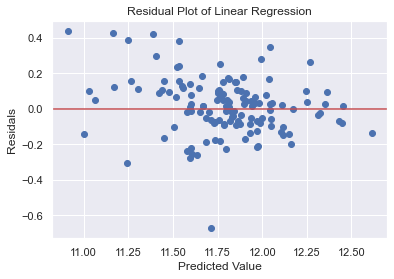

In [53]:
plot_residual(y_pred, y_dev, model_name = 'Linear Regression')

In [54]:
X, y = new_houses_train.drop(['YearBuilt', 'SalePrice', 'SalePriceLog'], axis=1), new_houses_train['SalePriceLog']
X_train, X_dev, y_train, y_dev = split_model(X, y)
y_pred, lr_model = evaluate_model(X_train, X_dev, y_train, y_dev, 'linear_regression')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

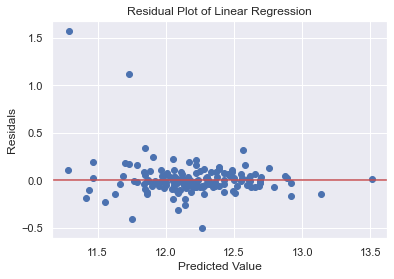

In [55]:
plot_residual(y_pred, y_dev, model_name = 'Linear Regression')

### 3.5 Cross validation

In [56]:
# Validation function
n_folds = 5

def model_cross_val(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf)).mean()
    return rmse

### 3.6 Model selection

In [57]:
# Lasso ridge
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

# Elastic net
enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# Kernel ridge
krr = KernelRidge(alpha=0.6,
                  kernel='polynomial',
                  degree=2,
                  coef0=2.5
                 )

# Gradient boosting
gboost = GradientBoostingRegressor(n_estimators=3000,
                                   learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15,
                                   min_samples_split=10, 
                                   loss='huber',
                                   random_state=5
                                  )

# XGBoost
xgboost = xgb.XGBRegressor(colsample_bytree=0.4603,
                           gamma=0.0468, 
                           learning_rate=0.05,
                           max_depth=3, 
                           min_child_weight=1.7817,
                           n_estimators=2200,
                           reg_alpha=0.4640,
                           reg_lambda=0.8571,
                           subsample=0.5213,
                           silent=1,
                           random_state=7,
                           nthread=-1
                          )

# LightGB
lgboost = lgb.LGBMRegressor(objective='regression',
                            num_leaves=5,
                            learning_rate=0.05, 
                            n_estimators=720,
                            max_bin=55,
                            bagging_fraction=0.8,
                            bagging_freq=5,
                            feature_fraction=0.2319,
                            feature_fraction_seed=9,
                            bagging_seed=9,
                            min_data_in_leaf=6,
                            min_sum_hessian_in_leaf=11
                           )

# Random forest
rforest = RandomForestRegressor(max_depth=2, random_state=0)

names = ['Lasso', 'Elastic Net', 'Kernel Ridge', 'Gradient Boost', 'XGBoost', 'LightGB', 'Random Forest']
models = [lasso, enet, krr, gboost, xgboost, lgboost, rforest]

models = dict(zip(names, models))

In [58]:
def model_cross_val(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf)).mean()
    return rmse

In [59]:
%%time
# Note this cell takes a very long time to execute unless using a GPU 
# print("RMSE for each model in our set")
# print("------------------------------")

# for name, model in models.items():
#     rmse = model_cross_val(model, X_train, y_train)
#     print("{}: {:4f}".format(name, rmse))

# print("\n")

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [60]:
%%time
# Note this cell takes a very long time to execute unless using a GPU 
# print("Residual plot for each model in our set")
# print("------------------------------")

# for name, model in models.items():
#     plt.title(f'{name}')
#     fitted_model = model.fit(X_train, y_train)
#     y_pred = fitted_model.predict(X_dev)
#     plot_residual(y_pred, y_dev, model_name=name)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11 µs


Out of these models, XGBoost has the best residual plot.

### Looking at XGBoost in more detail
Since XGBoost produced the lowest error, we now do the error analysis on this model to improve it.

In [61]:
X, y = house_train.drop(['SalePrice','SalePriceLog'], axis=1), house_train['SalePriceLog']
X_train, X_dev, y_train, y_dev = split_model(X, y)
y_pred, xgb_model = evaluate_model(X_train, X_dev, y_train, y_dev, 'xgboost')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [62]:
top_10_percent_of_X_dev = int(X_dev.shape[0] * 0.1)
X_largest_residuals = get_largest_residuals(y_pred, y_dev, n=top_10_percent_of_X_dev)
get_p_values_of_difference(X_largest_residuals, X_dev)

LotFrontage p-value: 0.155
LotArea p-value: 0.008
OverallQual p-value: 0.224
YearBuilt p-value: 0.008
YearRemodAdd p-value: 0.162
MasVnrArea p-value: 0.78
BsmtFinSF1 p-value: 0.381
BsmtFinSF2 p-value: 0.154
BsmtUnfSF p-value: 0.072
TotalBsmtSF p-value: 0.438
1stFlrSF p-value: 0.409
2ndFlrSF p-value: 0.957
LowQualFinSF p-value: 0.512
GrLivArea p-value: 0.772
BsmtFullBath p-value: 0.916
BsmtHalfBath p-value: 0.291
FullBath p-value: 0.367
HalfBath p-value: 0.794
BedroomAbvGr p-value: 0.199
KitchenAbvGr p-value: 0.864
TotRmsAbvGrd p-value: 0.341
Fireplaces p-value: 0.309
GarageYrBlt p-value: 0.78
GarageCars p-value: 0.435
GarageArea p-value: 0.125
WoodDeckSF p-value: 0.495
OpenPorchSF p-value: 0.692
EnclosedPorch p-value: 0.56
3SsnPorch p-value: 0.39
ScreenPorch p-value: 0.517
PoolArea p-value: 0.753
MiscVal p-value: 0.032
MoSold p-value: 0.636
YrSold p-value: 0.383
TotalSF p-value: 0.662
TotalBathrooms p-value: 0.627
TotalPorchSF p-value: 0.512
HasBsmt p-value: 0.914
GrLivAreaLog p-value:

Similar to linear regression, the p-value for built year is also low. The overall quality is also low. Hence we can potentially build separate models based on those.

### 3.7 Feature selection - investigate features to trim those with 0 importance

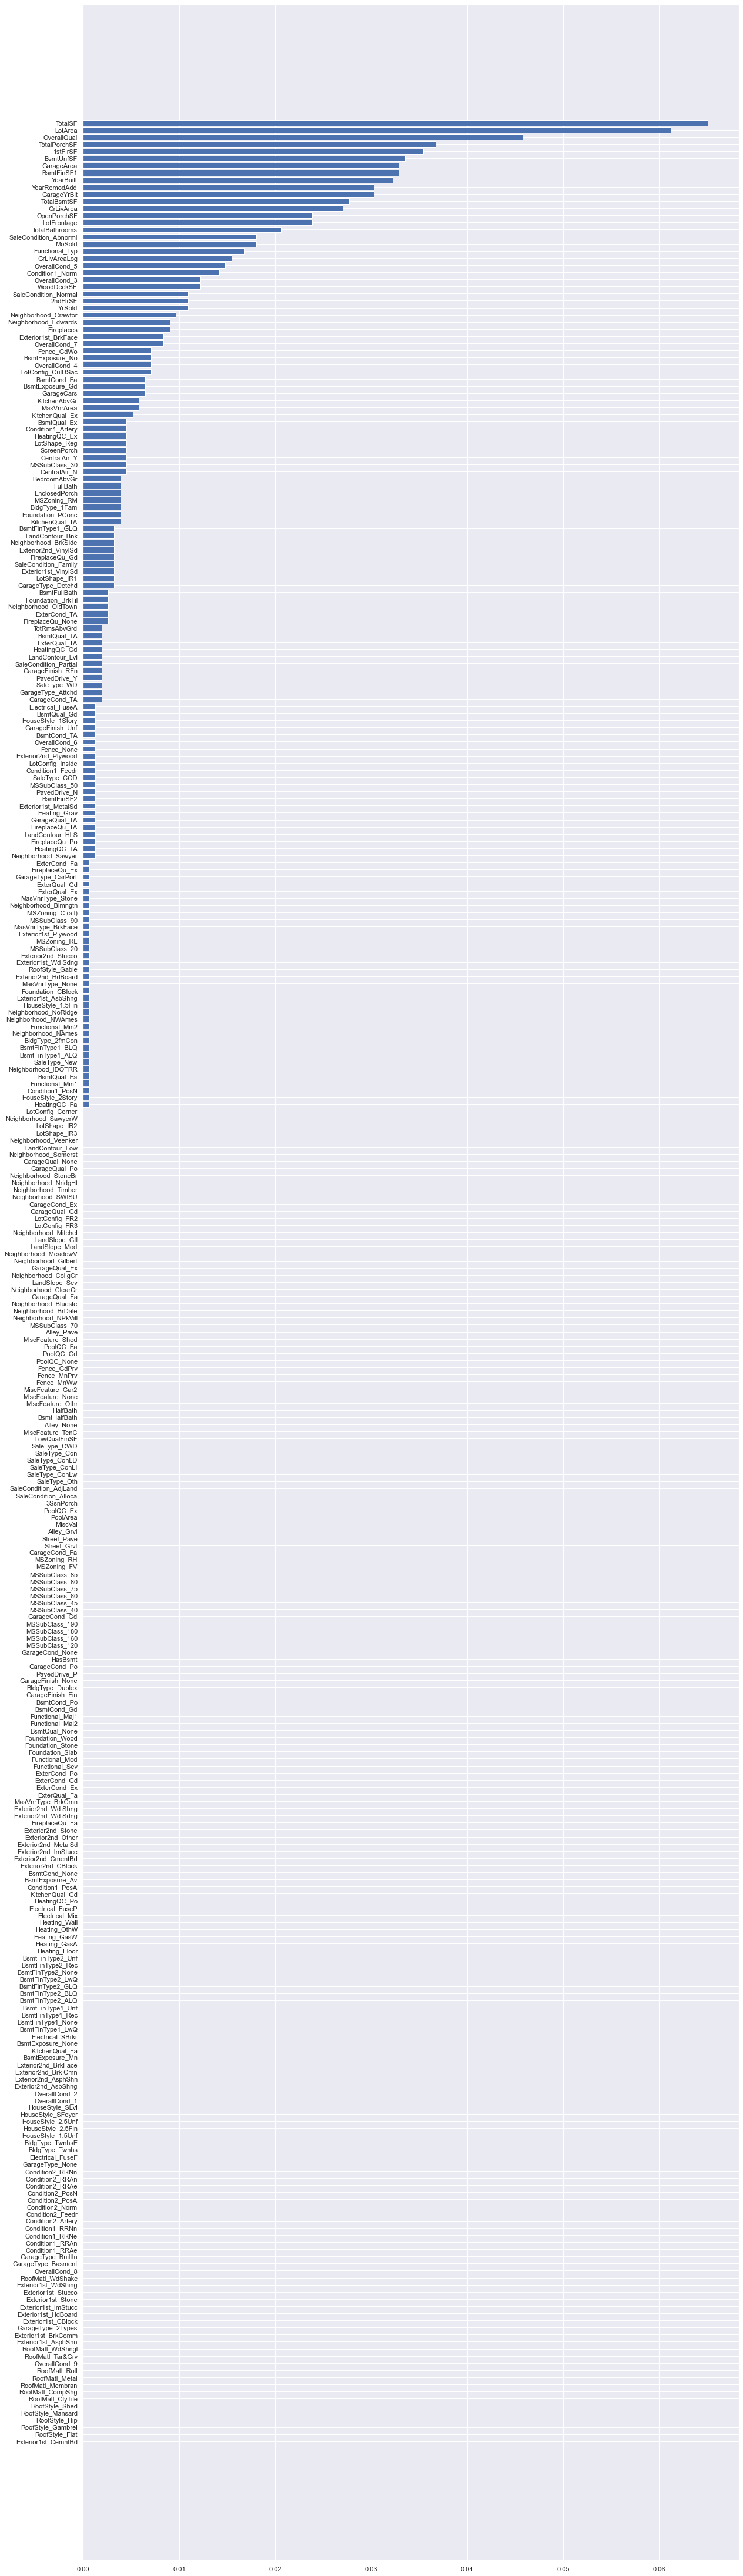

In [63]:
fig, ax = plt.subplots(figsize=(20,80))

features = X_train.columns
importances = xgb_model.feature_importances_
feature_importances = pd.DataFrame(data={'feature':features,
                                         'importance': importances
                                        }
                                  )\
                        .sort_values(by=['importance'])

ax.barh(feature_importances['feature'], feature_importances['importance'])
plt.show()

In [64]:
print(feature_importances[feature_importances['importance'] > 0]\
      .sort_values(by='importance', ascending=False)\
      .to_string()
     )

                   feature  importance
34                 TotalSF    0.065077
1                  LotArea    0.061211
2              OverallQual    0.045747
36            TotalPorchSF    0.036727
10                1stFlrSF    0.035438
8                BsmtUnfSF    0.033505
24              GarageArea    0.032861
6               BsmtFinSF1    0.032861
3                YearBuilt    0.032216
4             YearRemodAdd    0.030284
22             GarageYrBlt    0.030284
9              TotalBsmtSF    0.027706
13               GrLivArea    0.027062
26             OpenPorchSF    0.023840
0              LotFrontage    0.023840
35          TotalBathrooms    0.020619
32                  MoSold    0.018041
321  SaleCondition_Abnorml    0.018041
265         Functional_Typ    0.016753
38            GrLivAreaLog    0.015464
139          OverallCond_5    0.014820
107        Condition1_Norm    0.014175
137          OverallCond_3    0.012242
25              WoodDeckSF    0.012242
325   SaleCondition_Norma

In [65]:
features_to_keep = list(feature_importances[feature_importances['importance'] > 0]['feature'])
new_house_train = house_train[features_to_keep]

In [66]:
X, y = new_house_train, house_train['SalePriceLog']
X_train, X_dev, y_train, y_dev = split_model(X, y)
y_pred, new_xgb_model = evaluate_model(X_train, X_dev, y_train, y_dev, 'xgboost')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

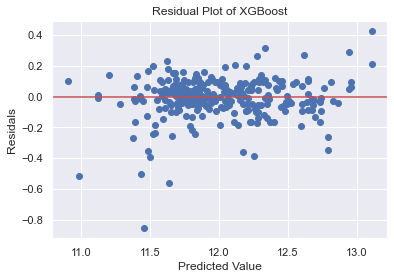

In [67]:
plot_residual(y_pred, y_dev, model_name = 'XGBoost')

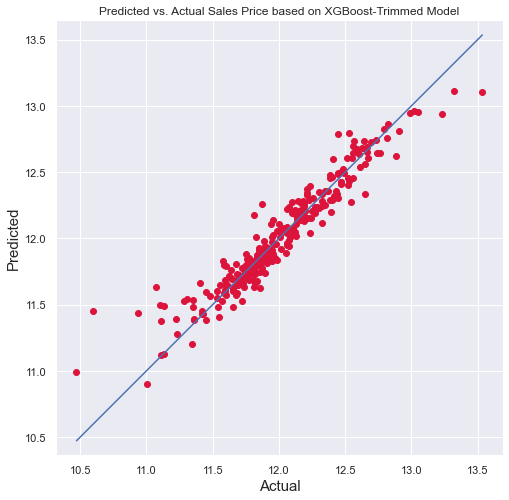

In [68]:
plt.figure(figsize=(8,8))
plt.scatter(y_dev, y_pred, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(y_pred), max(y_dev))
p2 = min(min(y_pred), min(y_dev))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Predicted vs. Actual Sales Price based on XGBoost-Trimmed Model')
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)
plt.axis('equal')
plt.show()

## 4.0 Model generalization

In [69]:
house_test = pd.read_csv('../data/test.csv')

In [70]:
house_test = handle_missing_data(house_test,
                                  drop_features,
                                  none_features,
                                  med_features,
                                  mode_features,
                                  convert_features
                                 )

house_test = custom_feature_engineering(house_test, train=False)
house_test = normalize_skewed_features(house_test, train=False)

# Simple pandas function to replicate a OneHotEncoder
house_test = pd.get_dummies(house_test)

In [71]:
new_house_test = house_test[features_to_keep]

# Apply inverse log transform to align with Kaggle submission requirements
test_preds = new_xgb_model.predict(new_house_test)
test_preds = np.exp(test_preds)

submission = pd.DataFrame(test_preds, columns={'SalePrice'}, index=range(1461,(1461+1459)))

In [72]:
submission.to_csv('../data/submission.csv', index_label='Id')